In [4]:
# !pip install matplotlib

In [1]:
from json import load as json_load
from os import listdir
from os.path import isfile, join
from pprint import pprint as pp

from matplotlib import pyplot as plt
import numpy as np

In [2]:
FILEPATH = 'results/'

In [3]:
onlyfiles = [(f, join(FILEPATH, f)) for f in listdir(FILEPATH) if isfile(join(FILEPATH, f))]

In [4]:
datasets_names = []
for dataset, dataset_filepath in onlyfiles:
    datasets_names.append(
        dataset.split('.')[0],
    )

In [5]:
datasets_names

['nba',
 'yelp_expanded',
 'yelp_expanded-Assisted',
 'twitter',
 'imdb-assisted-single-query',
 'dblp-Assisted',
 'imdb',
 'twitter-Assisted',
 'dblp',
 'nba-Assisted',
 'imdb-Assisted']

## Generation Time experiment

In [6]:
phase_times_per_dataset = {}
phase_times = {
    'km': [],
    'qm': [],
    'cn': [],
    'cn_bottom': [],
}
phase_times_labels = []

for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)
    
    current_dataset_name = dataset.split('.')[0]
    
    if current_dataset_name == 'yelp':
        continue
    
    if 'compound' in current_dataset_name:
        continue
    
    print(f'Current dataset: {current_dataset_name}')

    skm_times = []
    vkm_times = []
    km_times = []
    qm_times = []
    cn_times = []
    total_times = []

    for keyword_query_result in current_dataset_content['results']:
        phases_time = keyword_query_result['elapsed_time']
        skm_gen_time = phases_time['skm']
        vkm_gen_time = phases_time['vkm']
        km_gen_time = phases_time['km']
        qm_gen_time = phases_time['qm']
        cn_gen_time = phases_time['cn']
        total_gen_time = phases_time['total']

        skm_times.append(skm_gen_time)
        vkm_times.append(vkm_gen_time)
        km_times.append(km_gen_time)
        qm_times.append(qm_gen_time)
        cn_times.append(cn_gen_time)
        total_times.append(total_gen_time)
    
    average_km_time = sum(km_times)/len(km_times)
    average_qm_time = sum(qm_times)/len(qm_times)
    average_cn_time = sum(cn_times)/len(cn_times)

    # if current_dataset_name == 'dblp':
    #     print(km_times)
    #     print(skm_times)
    #     print(vkm_times)
    
    phase_times['km'].append(average_km_time)
    phase_times['qm'].append(average_qm_time)
    phase_times['cn'].append(average_cn_time)
    phase_times['cn_bottom'].append(average_km_time + average_qm_time)
    phase_times_labels.append(current_dataset_name)
    
    phase_times_per_dataset[current_dataset_name] = [
        average_km_time,
        average_qm_time,
        average_cn_time,
    ]

    print('Average KM time => {:.5f}'.format(average_km_time * 1000))
    print('Average QM time => {:.5f}'.format(average_qm_time * 1000))
    print('Average CN time => {:.5f}'.format(average_cn_time * 1000))
    print('Total time => {:.5f}\n'.format((average_km_time + average_qm_time + average_cn_time) * 1000))

Current dataset: nba
Average KM time => 69.56484
Average QM time => 2.33981
Average CN time => 440.27833
Total time => 512.18298

Current dataset: yelp_expanded
Average KM time => 105.43051
Average QM time => 152.57577
Average CN time => 1240.97869
Total time => 1498.98497

Current dataset: yelp_expanded-Assisted
Average KM time => 81.74646
Average QM time => 150.64157
Average CN time => 942.22557
Total time => 1174.61360

Current dataset: twitter
Average KM time => 71.65018
Average QM time => 0.56688
Average CN time => 5206.57663
Total time => 5278.79369

Current dataset: imdb-assisted-single-query
Average KM time => 2.75661
Average QM time => 1.42770
Average CN time => 507.38899
Total time => 511.57330

Current dataset: dblp-Assisted
Average KM time => 2.00395
Average QM time => 2.86659
Average CN time => 2422.05202
Total time => 2426.92256

Current dataset: imdb
Average KM time => 26.37085
Average QM time => 21.07380
Average CN time => 228.94441
Total time => 276.38906

Current data

In [7]:
# phase_times

['nba', 'yelp_expanded', 'yelp_expanded-Assisted', 'twitter', 'imdb-assisted-single-query', 'dblp-Assisted', 'imdb', 'twitter-Assisted', 'dblp', 'nba-Assisted', 'imdb-Assisted']


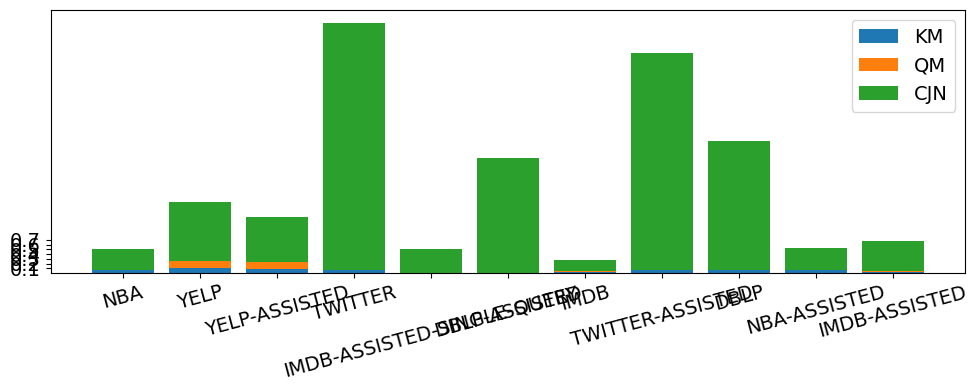

In [8]:
fig, ax = plt.subplots()

labels = []
for label in phase_times_labels:
    labels.append(
        label.upper().replace('_COMPOUND', '-CP').replace('_EXPANDED', '').replace('-Assisted', '-AR')
    )

print(phase_times_labels)

ax.bar(
    labels,
    phase_times['km'],
    label='KM',
)

ax.bar(
    labels,
    phase_times['qm'],
    bottom=phase_times['km'],
    label='QM'
)

ax.bar(
    labels,
    phase_times['cn'],
    bottom=phase_times['cn_bottom'],
    label='CJN'
)

fig.set_size_inches(10, 4)
ax.set_xticks(range(len(phase_times_labels)), labels, rotation=15, fontsize=14)
ax.set_yticks([tick for tick in np.arange(0.1, 0.8, 0.1)], [f'{tick:.1f}' for tick in np.arange(0.1, 0.8, 0.1)], fontsize=14)

# plt.yscale('log')
plt.legend(
    fontsize=14,
)
fig.tight_layout()
plt.savefig('images/generation_time_results.pdf')
plt.show()


## MRR and P@K metrics

In [9]:
labels = ['mrr']

datasets_metrics_qm_data = {}
datasets_metrics_cn_data = {}

for i in range(1, 10):
    labels.append(
        'p@' + str(i),
    )

for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)

    current_dataset_name = dataset.split('.')[0]
    datasets_metrics_qm_data[current_dataset_name] = []
    evaluation_results = current_dataset_content['evaluation']

    query_match_results = evaluation_results['query_matches']
    for key in query_match_results:
        if key in labels:
            datasets_metrics_qm_data[current_dataset_name].append(
                query_match_results[key],
            )

In [10]:
# pp(datasets_metrics_qm_data)

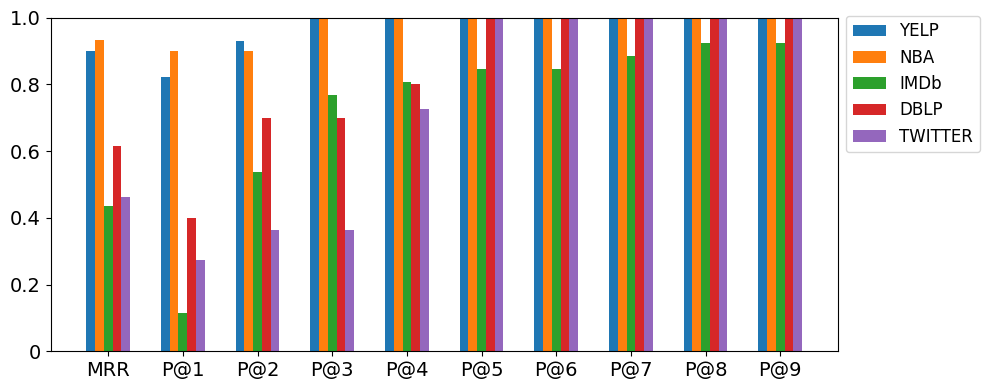

In [11]:
fig, ax = plt.subplots()
x = np.arange(0, len(labels) * 3, 3)
width = 0.35

labels_upper = [label.upper() for label in labels]

yelp = ax.bar(x - (2*width), datasets_metrics_qm_data['yelp_expanded'], width, label='YELP')
# nba_compound = ax.bar(x - (2*width), datasets_metrics_qm_data['nba_compound'], width, label='NBA-CP')
nba = ax.bar(x - width, datasets_metrics_qm_data['nba'], width, label='NBA')
imdb = ax.bar(x, datasets_metrics_qm_data['imdb'], width, label='IMDb')
# imdb_compound = ax.bar(x  + width, datasets_metrics_qm_data['imdb_compound'], width, label='IMDb-CP')
dblp = ax.bar(x  + (1*width), datasets_metrics_qm_data['dblp'], width, label='DBLP')
twitter = ax.bar(x  + (2*width), datasets_metrics_qm_data['twitter'], width, label='TWITTER')

ax.set_xticks(x, labels_upper, fontsize=14)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
ax.set_ylim([0, 1])
fig.set_size_inches(10, 4)

ax.legend(
    bbox_to_anchor=(1, 1.03),
    fontsize=12,
)

fig.tight_layout()
plt.savefig('images/qm_evaluation.pdf')
plt.show()

In [12]:
(datasets_metrics_qm_data['yelp_expanded'][0] + datasets_metrics_qm_data['imdb'][0] + datasets_metrics_qm_data['dblp'][0] + datasets_metrics_qm_data['nba'][0] + datasets_metrics_qm_data['twitter'][0])/5

0.6690157047253822

In [13]:
(datasets_metrics_qm_data['yelp_expanded'][0] + datasets_metrics_qm_data['nba'][0])/2

0.9160714285714286

In [14]:
# (datasets_metrics_qm_data['yelp_expanded'][0] + datasets_metrics_qm_data['imdb_compound'][0] + datasets_metrics_qm_data['dblp'][0] + datasets_metrics_qm_data['nba_compound'][0] + datasets_metrics_qm_data['twitter'][0])/5

In [15]:
labels = ['mrr']

datasets_metrics_cn_data = {}

for i in range(1, 7):
    labels.append(
        'p@' + str(i),
    )

for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)

    current_dataset_name = dataset.split('.')[0]
    datasets_metrics_cn_data[current_dataset_name] = []
    evaluation_results = current_dataset_content['evaluation']

    candidate_networks_results = evaluation_results['candidate_networks']
    for key in candidate_networks_results:
        if key in labels:
            datasets_metrics_cn_data[current_dataset_name].append(
                candidate_networks_results[key],
            )

In [16]:
pp(datasets_metrics_cn_data)

{'dblp': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'dblp-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'imdb': [0.4211538461538461,
          0.11538461538461539,
          0.5384615384615384,
          0.7692307692307693,
          0.8076923076923077,
          0.8461538461538461,
          0.8461538461538461],
 'imdb-Assisted': [0.4332267091882476,
                   0.11538461538461539,
                   0.5384615384615384,
                   0.7692307692307693,
                   0.8076923076923077,
                   0.8461538461538461,
                   0.8461538461538461],
 'imdb-assisted-single-query': [0.3333333333333333,
                                0.0,
                                0.0,
                                1.0,
                                1.0,
                                1.0,
                                1.0],
 'nba': [0.9333333333333333, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0],
 'nba-Assisted': [0.9333333333333333, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0],
 'twitte

[ 0  3  6  9 12 15 18]
['MRR', 'P@1', 'P@2', 'P@3', 'P@4', 'P@5', 'P@6']


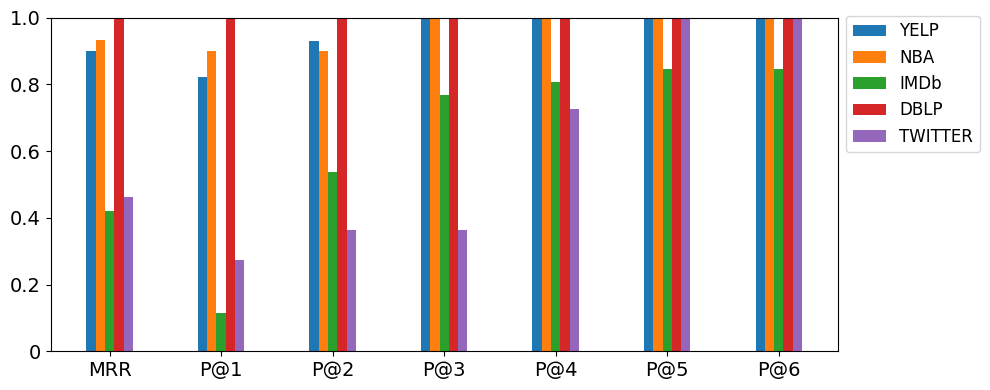

In [17]:
fig, ax = plt.subplots()
x = np.arange(0, len(labels) * 3, 3)
width = 0.25

print(x)

labels_upper = [label.upper() for label in labels]
print(labels_upper)

yelp = ax.bar(x - (2*width), datasets_metrics_cn_data['yelp_expanded'], width, label='YELP')
# nba_compound = ax.bar(x - (2*width), datasets_metrics_cn_data['nba_compound'], width, label='NBA-CP')
nba = ax.bar(x - width, datasets_metrics_cn_data['nba'], width, label='NBA')
imdb = ax.bar(x, datasets_metrics_cn_data['imdb'], width, label='IMDb')
# imdb_compound = ax.bar(x  + width, datasets_metrics_cn_data['imdb_compound'], width, label='IMDb-CP')
dblp = ax.bar(x  + (1*width), datasets_metrics_cn_data['dblp'], width, label='DBLP')
twitter = ax.bar(x  + (2*width), datasets_metrics_cn_data['twitter'], width, label='TWITTER')

ax.set_xticks(x, labels_upper, fontsize=14)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
ax.set_ylim([0, 1])
fig.set_size_inches(10, 4)

ax.legend(
    bbox_to_anchor=(1, 1.03),
    fontsize=12,
)

fig.tight_layout()
plt.savefig('images/cn_evaluation.pdf')
plt.show()

In [18]:
(datasets_metrics_cn_data['yelp_expanded'][0] + datasets_metrics_cn_data['imdb'][0] + datasets_metrics_cn_data['dblp'][0] + datasets_metrics_cn_data['nba'][0] + datasets_metrics_cn_data['twitter'][0])/5

0.7433866133866134

In [19]:
# datasets_metrics_cn_data

In [20]:
# (datasets_metrics_cn_data['yelp_expanded'][0] + datasets_metrics_cn_data['imdb_compound'][0] + datasets_metrics_cn_data['dblp'][0] + datasets_metrics_cn_data['nba_compound'][0] + datasets_metrics_cn_data['twitter'][0])/5

In [21]:
onlyfiles = [
 ('nba.json', 'results/nba.json'),
 ('nba-Assisted.json', 'results/nba-Assisted.json'),
 ('yelp_expanded.json', 'results/yelp_expanded.json'),
 ('yelp_expanded-Assisted.json', 'results/yelp_expanded-Assisted.json'),
 ('twitter.json', 'results/twitter.json'),
 ('twitter-Assisted.json', 'results/twitter-Assisted.json'),
 ('dblp.json', 'results/dblp.json'),
 ('dblp-Assisted.json', 'results/dblp-Assisted.json'),
 ('imdb.json', 'results/imdb.json'),
 ('imdb-Assisted.json', 'results/imdb-Assisted.json')
]

## Getting data for the number of correctly captured queries (using the CJN ranking)

In [22]:
relevant_query_positions_per_dataset = {}

for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)

    current_dataset_name = dataset.split('.')[0]
    datasets_metrics_qm_data[current_dataset_name] = []
    evaluation_results = current_dataset_content['evaluation']

    relevant_query_positions_per_dataset[dataset] = evaluation_results['candidate_networks']['relevant_positions']

In [23]:
relevant_query_positions_per_dataset

{'nba.json': [1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
 'nba-Assisted.json': [1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
 'yelp_expanded.json': [2,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1],
 'yelp_expanded-Assisted.json': [2,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1],
 'twitter.json': [1, 4, 1, 1, 5, 4, 4, 5, 4, 5, 2],
 'twitter-Assisted.json': [1, 4, 1, 1, 5, 4, 4, 5, 4, 5, 2],
 'dblp.json': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'dblp-Assisted.json': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'imdb.json': [1,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  -1,
  2,
  3,
  1,
  1,
  -1,
  2,
  2,
  5,
  2,
  4,
  2,
  -1,
  -1,
  3,
  3],
 'imdb-Assisted.json': [1,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  26,
  2,
  3,
  1,
  1,
  24,
  2,
  2,
  5,
  2,
  4,
  2,
  7,
  11,
  3,
  3]}

In [24]:
correctly_captured_queries_per_ranking_approach = {}

for dataset, positions in relevant_query_positions_per_dataset.items():
    correct_queries_count = 0

    print(dataset)
    print('Queryset length: {}'.format(len(positions)))
    
    if 'Assisted' in dataset:
        for position in positions:
            if position <= 5 and position > 0:
                correct_queries_count += 1
    else:
        for position in positions:
            if position == 1:
                correct_queries_count += 1

    correctly_captured_queries_per_ranking_approach[dataset] = correct_queries_count

nba.json
Queryset length: 10
nba-Assisted.json
Queryset length: 10
yelp_expanded.json
Queryset length: 28
yelp_expanded-Assisted.json
Queryset length: 28
twitter.json
Queryset length: 11
twitter-Assisted.json
Queryset length: 11
dblp.json
Queryset length: 10
dblp-Assisted.json
Queryset length: 10
imdb.json
Queryset length: 26
imdb-Assisted.json
Queryset length: 26


In [25]:
correctly_captured_queries_per_ranking_approach

{'nba.json': 9,
 'nba-Assisted.json': 10,
 'yelp_expanded.json': 23,
 'yelp_expanded-Assisted.json': 28,
 'twitter.json': 3,
 'twitter-Assisted.json': 11,
 'dblp.json': 10,
 'dblp-Assisted.json': 10,
 'imdb.json': 3,
 'imdb-Assisted.json': 22}

# Precision and Recall

In [26]:
average_precision_per_dataset = {}
average_recall_per_dataset = {}

for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)
    
    current_dataset_name = dataset.split('.')[0]
    if current_dataset_name == 'yelp':
        continue

    average_precision_per_dataset[current_dataset_name] = []
    average_recall_per_dataset[current_dataset_name] = []
    
    print(f'Current dataset: {current_dataset_name}')
    
    for keyword_query_retrieval_data in current_dataset_content['evaluation']['retrieval_score']:
        average_precision_per_dataset[
            current_dataset_name
        ].append(keyword_query_retrieval_data['precision'])
        
        average_recall_per_dataset[
            current_dataset_name
        ].append(keyword_query_retrieval_data['recall'])

Current dataset: nba
Current dataset: nba-Assisted
Current dataset: yelp_expanded
Current dataset: yelp_expanded-Assisted
Current dataset: twitter
Current dataset: twitter-Assisted
Current dataset: dblp
Current dataset: dblp-Assisted
Current dataset: imdb
Current dataset: imdb-Assisted


In [27]:
labels = []
average_precision_plot_data = []

for dataset in average_precision_per_dataset:
    if 'compound' in dataset:
        continue
    labels.append(dataset)
    average_precision = sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset])
    average_precision_plot_data.append(average_precision)
    print(f'Dataset: {dataset} - Average Precision: {average_precision:.3f}')

Dataset: nba - Average Precision: 1.000
Dataset: nba-Assisted - Average Precision: 1.000
Dataset: yelp_expanded - Average Precision: 1.000
Dataset: yelp_expanded-Assisted - Average Precision: 1.000
Dataset: twitter - Average Precision: 0.307
Dataset: twitter-Assisted - Average Precision: 1.000
Dataset: dblp - Average Precision: 1.000
Dataset: dblp-Assisted - Average Precision: 1.000
Dataset: imdb - Average Precision: 0.521
Dataset: imdb-Assisted - Average Precision: 0.812


In [28]:
average_recall_plot_data = []

for dataset in average_recall_per_dataset:
    if 'compound' in dataset:
        continue
    average_recall = sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset])
    average_recall_plot_data.append(average_recall)
    print(f'Dataset: {dataset} - Average Recall: {average_recall:.3f}')

Dataset: nba - Average Recall: 0.901
Dataset: nba-Assisted - Average Recall: 1.000
Dataset: yelp_expanded - Average Recall: 0.962
Dataset: yelp_expanded-Assisted - Average Recall: 0.962
Dataset: twitter - Average Recall: 0.207
Dataset: twitter-Assisted - Average Recall: 1.000
Dataset: dblp - Average Recall: 1.000
Dataset: dblp-Assisted - Average Recall: 1.000
Dataset: imdb - Average Recall: 0.286
Dataset: imdb-Assisted - Average Recall: 0.917


In [29]:
average_precision_per_dataset

{'nba': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'nba-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'yelp_expanded': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'yelp_expanded-Assisted': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'twitter': [1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.02527075812274368,
  0.0,
  0.0,
  0.041666666666666664],
 'twitter-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'dblp': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'dblp-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'imdb': [1.0,
  1.0,
  0.4,
  1.0,
  0.45454545454545453,
  0.8333333333333334,
  0.3333333333333333,
  0.75,
  0.0,
  0.5,
  0.3333333333333333,
  0.0,
  0

In [30]:
average_recall_per_dataset

{'nba': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.007972665148063782],
 'nba-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'yelp_expanded': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.05970149253731343,
  1.0,
  1.0,
  1.0,
  1.0],
 'yelp_expanded-Assisted': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.05970149253731343,
  1.0,
  1.0,
  1.0,
  1.0],
 'twitter': [1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.030303030303030304,
  0.006930693069306931,
  0.0,
  0.0,
  0.03278688524590164],
 'twitter-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'dblp': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'dblp-Assisted': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'imdb': [1.0,
  0.047619047619047616,
  0.2,
  0.017241379310344827,
  0.14084507042253522

In [31]:
# Precision and Recall for datasets without compound keywords
precision = 0.0
recall = 0.0

datasets_precision = []
datasets_recall = []

for dataset in average_precision_per_dataset:
    if dataset.endswith('-Assisted'):
        continue
    print('Valid dataset: {}'.format(dataset))
    print('Prec: {} | Rec: {}'.format(sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset]), sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset])))
    datasets_precision.append(sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset]))
    datasets_recall.append(sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset]))

print('[Default] Average Precision: {}'.format(sum(datasets_precision)/len(datasets_precision)))
print('[Default] Average Recall: {}'.format(sum(datasets_recall)/len(datasets_recall)))

Valid dataset: nba
Prec: 1.0 | Rec: 0.9007972665148063
Valid dataset: yelp_expanded
Prec: 1.0 | Rec: 0.9623880597014925
Valid dataset: twitter
Prec: 0.306693742478941 | Rec: 0.20700206086182388
Valid dataset: dblp
Prec: 1.0 | Rec: 1.0
Valid dataset: imdb
Prec: 0.5205762987012986 | Rec: 0.2859916701438179
[Default] Average Precision: 0.7654540082360479
[Default] Average Recall: 0.6712358114443882


In [32]:
# Precision and Recall for datasets without compound keywords
precision = 0.0
recall = 0.0

datasets_precision = []
datasets_recall = []

for dataset in average_precision_per_dataset:
    if not dataset.endswith('-Assisted'):
        continue
    print('Valid dataset: {}'.format(dataset))
    print('Prec: {} | Rec: {}'.format(sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset]), sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset])))
    datasets_precision.append(sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset]))
    datasets_recall.append(sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset]))

print('[Assisted] Average Precision: {}'.format(sum(datasets_precision)/len(datasets_precision)))
print('[Assisted] Average Recall: {}'.format(sum(datasets_recall)/len(datasets_recall)))

Valid dataset: nba-Assisted
Prec: 1.0 | Rec: 1.0
Valid dataset: yelp_expanded-Assisted
Prec: 1.0 | Rec: 0.9623880597014925
Valid dataset: twitter-Assisted
Prec: 1.0 | Rec: 1.0
Valid dataset: dblp-Assisted
Prec: 1.0 | Rec: 1.0
Valid dataset: imdb-Assisted
Prec: 0.8125 | Rec: 0.9166666666666666
[Assisted] Average Precision: 0.9625
[Assisted] Average Recall: 0.9758109452736319


In [33]:
# Precision and Recall for datasets without compound keywords
# precision = 0.0
# recall = 0.0

# datasets_precision = []
# datasets_recall = []

# for dataset in average_precision_per_dataset:
#     if dataset in ['imdb', 'nba']:
#         continue
#     print('Valid dataset: {}'.format(dataset))
#     datasets_precision.append(sum(average_precision_per_dataset[dataset])/len(average_precision_per_dataset[dataset]))
#     datasets_recall.append(sum(average_recall_per_dataset[dataset])/len(average_recall_per_dataset[dataset]))

# print('Average Precision without compound: {}'.format(sum(datasets_precision)/len(datasets_precision)))
# print('Average Recall without compound: {}'.format(sum(datasets_recall)/len(datasets_recall)))

In [34]:
# datasets_precision

In [35]:
# datasets_recall

In [36]:
# average_precision_plot_data

In [37]:
# average_recall_plot_data

['NBA-DR', 'NBA-AR', 'YELP-DR', 'YELP-AR', 'TWITTER-DR', 'TWITTER-AR', 'DBLP-DR', 'DBLP-AR', 'IMDB-DR', 'IMDB-AR']


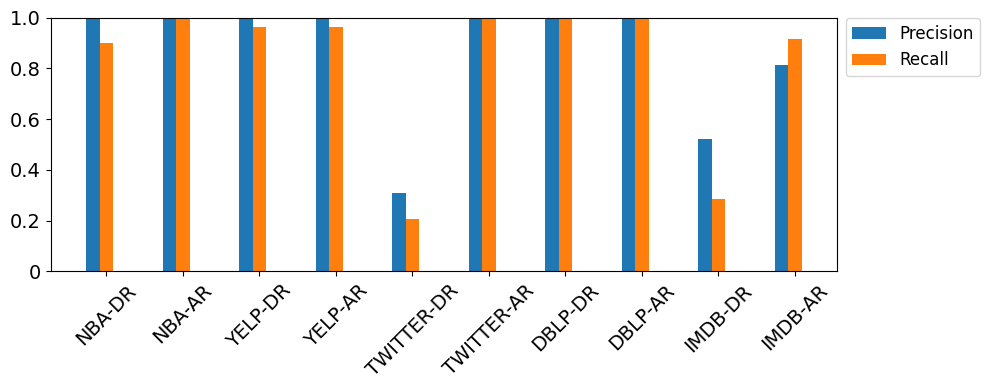

In [38]:
fig, ax = plt.subplots()
x = np.arange(0, len(labels) * 2, 2)
width = 0.35

new_labels = []
for label in labels:
    if '-Assisted' not in label:
        new_labels.append(label + '-dr')
        continue
    new_labels.append(label)
labels = new_labels

labels_upper = [label.upper().replace('_EXPANDED', '').replace('-ASSISTED', '-AR').replace('-dr', '-DR') for label in labels]
# labels_upper = [item.replace('_EXPANDED', '').replace('_COMPOUND', '-CP') for item in labels_upper]
print(labels_upper)

precision = ax.bar(x - width, average_precision_plot_data, width, label='Precision')
recall = ax.bar(x, average_recall_plot_data, width, label='Recall')

ax.set_xticks(x, labels_upper, rotation=45, fontsize=14)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
ax.set_ylim([0, 1])
fig.set_size_inches(10, 4)

ax.legend(
    bbox_to_anchor=(1, 1.03),
    fontsize=12,
)

fig.tight_layout()
plt.savefig('images/quality_results.pdf')
plt.show()

# KMs, QMs and CJNs statistics

In [32]:
for dataset, dataset_filepath in onlyfiles:
    with open(dataset_filepath) as f:
        current_dataset_content = json_load(f)
    
    current_dataset_name = dataset.split('-')[0]
    if current_dataset_name == 'yelp':
        continue
        
    if 'compound' in dataset:
        continue
    
    print(f'Current dataset: {current_dataset_name}')
    
    schema_keyword_match_count = current_dataset_content['evaluation']['num_schema_keyword_matches']
    value_keyword_match_count = current_dataset_content['evaluation']['num_value_keyword_matches']
    query_match_count = current_dataset_content['evaluation']['num_query_matches']
    candidate_network_count = current_dataset_content['evaluation']['num_candidate_networks']

    average_skm_count = sum(schema_keyword_match_count)/len(schema_keyword_match_count)
    average_vkm_count = sum(value_keyword_match_count)/len(value_keyword_match_count)
    average_qm_count = sum(query_match_count)/len(query_match_count)
    average_cn_count = sum(candidate_network_count)/len(candidate_network_count)
    
    max_skm_count = max(schema_keyword_match_count)
    max_vkm_count = max(value_keyword_match_count)
    max_qm_count = max(query_match_count)
    max_cn_count = max(candidate_network_count)
    
    print('Average SKM Count: {} | Max SKM Count: {}'.format(
        average_skm_count,
        max_skm_count,
    ))
    
    print('Average VKM Count: {} | Max VKM Count: {}'.format(
        average_vkm_count,
        max_vkm_count,
    ))
    
    print('Average QM Count: {} | Max QM Count: {}'.format(
        average_qm_count,
        max_qm_count,
    ))
    
    print('Average CN Count: {} | Max CN Count: {}'.format(
        average_cn_count,
        max_cn_count,
    ))
    
    print()

Current dataset: nba.json
Average SKM Count: 0.5 | Max SKM Count: 2
Average VKM Count: 2.6 | Max VKM Count: 5
Average QM Count: 2.0 | Max QM Count: 5
Average CN Count: 1.2 | Max CN Count: 3

Current dataset: nba
Average SKM Count: 0.5 | Max SKM Count: 2
Average VKM Count: 2.6 | Max VKM Count: 5
Average QM Count: 2.0 | Max QM Count: 5
Average CN Count: 1.2 | Max CN Count: 3

Current dataset: yelp_expanded.json
Average SKM Count: 0.9642857142857143 | Max SKM Count: 3
Average VKM Count: 15.357142857142858 | Max VKM Count: 37
Average QM Count: 72.14285714285714 | Max QM Count: 497
Average CN Count: 49.785714285714285 | Max CN Count: 318

Current dataset: yelp_expanded
Average SKM Count: 0.9642857142857143 | Max SKM Count: 3
Average VKM Count: 15.357142857142858 | Max VKM Count: 37
Average QM Count: 72.14285714285714 | Max QM Count: 497
Average CN Count: 49.785714285714285 | Max CN Count: 318

Current dataset: twitter.json
Average SKM Count: 0.18181818181818182 | Max SKM Count: 2
Average VK

# Query Generation and Execution times

In [55]:
for dataset, filepath in onlyfiles:
    if dataset.endswith('-Assisted.json') or dataset.endswith('-query.json'):
        continue
    print('Analysing dataset {}'.format(dataset))
    with open(filepath) as f:
        content = json_load(f)
    results = content['results']
    
    query_generation_times = []
    query_execution_times = []
    
    for query_data in results:
        # print('Keyword Query: {}'.format(query_data['keyword_query']))
        query_generation_time = query_data['query_generation_time']
        query_execution_time = query_data['query_execution_time']
        
        query_generation_times.append(
            query_generation_time,
        )
        query_execution_times.append(
            query_execution_time,
        )
    
    average_generation_time = sum(query_generation_times)/len(query_generation_times)

    average_execution_time = sum(query_execution_times)/len(query_execution_times)
    
    print('Avg. Generation Time: {}'.format(average_generation_time * 1000))
    print('Avg. Execution Time: {}'.format(average_execution_time * 1000))
    print('Max. Generation Time: {}'.format(max(query_generation_times) * 1000))
    print('Max. Execution Time: {}'.format(max(query_execution_times) * 1000))
    print()

Analysing dataset nba.json
Avg. Generation Time: 0.17723639975883998
Avg. Execution Time: 450.74150519976683
Max. Generation Time: 0.2753829976427369
Max. Execution Time: 1009.0536549978424

Analysing dataset yelp_expanded.json
Avg. Generation Time: 0.23243142836041183
Avg. Execution Time: 616.9352365710178
Max. Generation Time: 1.3119349969201721
Max. Execution Time: 9014.320542999485

Analysing dataset twitter.json
Avg. Generation Time: 0.24394018228948963
Avg. Execution Time: 4016.003471362968
Max. Generation Time: 0.3433439997024834
Max. Execution Time: 6024.269886002003

Analysing dataset dblp.json
Avg. Generation Time: 0.23526230070274323
Avg. Execution Time: 2521.4060991973383
Max. Generation Time: 0.3313839988550171
Max. Execution Time: 3669.597252999665

Analysing dataset imdb.json
Avg. Generation Time: 0.18207592340611603
Avg. Execution Time: 217.57098411538976
Max. Generation Time: 0.3858440013573272
Max. Execution Time: 483.16922599951795

